In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import numpy as np

device = torch.device('cpu')

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

The MLP consists of two linear projections separated by a
GELU nonlinearity

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

### Factorised Dot-product Attention Transformer Encoder (Model 4)

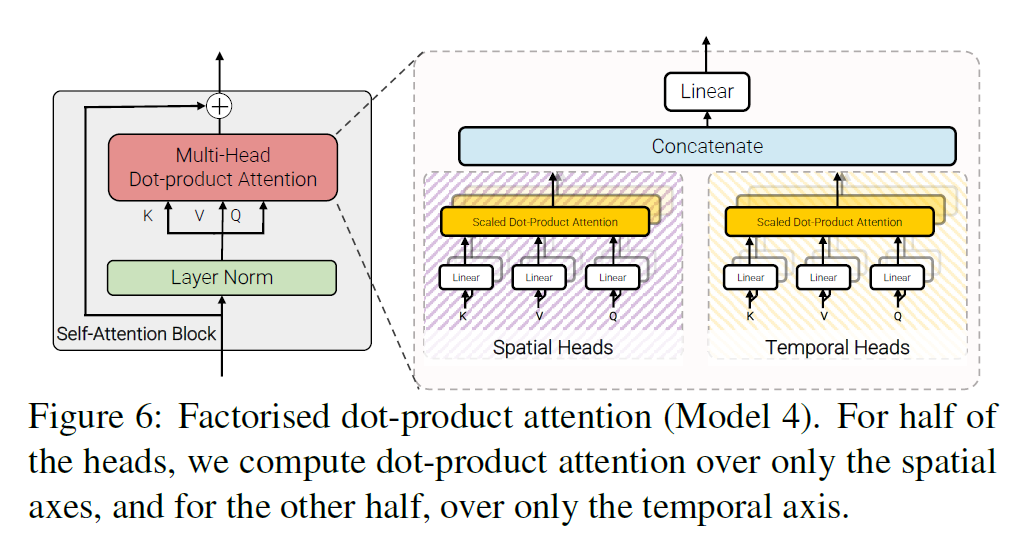
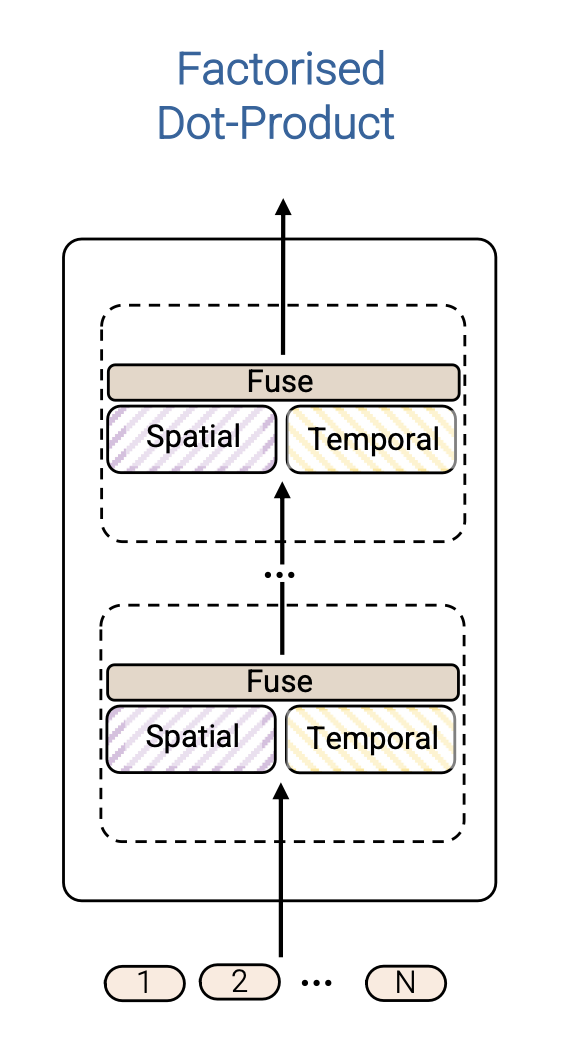

- Q = X Wq
- K = X Wk
- V = X Wv

X, Q, K, V ∈ R^N×d. N =nt ·nh ·nw.<br>
the spatial and temporal dimensions are merged<br>
Ks,Vs ∈ R^nh·nw×d<br>
Kt,Vt ∈ R^nt×d<br>
<br>
Ys = Attention(Q, Ks, Vs)<br>
Yt = Attention(Q, Kt, Vt)<br>
Ys, Yt ∈ R^N×d<br>
Y = Concat(Ys,Yt)WO<br>

In [ ]:
class FDAttention(nn.Module):
    """Factorized Dot-product Attention"""
    def __init__(self, dim, nt, nh, nw, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.nt = nt
        self.nh = nh
        self.nw = nw

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # x = [batch, n_t*n_h*n_w, dim]
        b, n, d, h = *x.shape, self.heads
        # b = batch
        # n = n_t*n_h*n_w
        # d = dim
        # h = heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        # self.to_qkv(x) = [batch, n_t*n_h*n_w, inner_dim*3]
        # qkv = [3, batch, n_t*n_h*n_w, inner_dim]

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # q, k, v = [batch, heads, n_t*n_h*n_w, dim_head]

        qs, qt = q.chunk(2, dim=1)
        ks, kt = k.chunk(2, dim=1)
        vs, vt = v.chunk(2, dim=1)
        # qs, qt, ks, kt, vs, vt = [batch, heads//2, n_t*n_h*n_w, dim_head]
        # qkv를 시간, 공간으로 나누어 줌

        # Attention over spatial dimension

        qs = qs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        ks, vs = ks.view(b, h // 2, self.nt, self.nh * self.nw, -1), vs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        ## ks, vs, qs = [batch, heads//2, n_t, n_h*n_w, dim_head]

        spatial_dots = einsum('b h t i d, b h t j d -> b h t i j', qs, ks) * self.scale
        ## qs*ks = [batch, heads//2, n_t, query_dim, dim_head] * [batch, heads//2, n_t, key_dim, dim_head] 
        ##      -> [batch, heads//2, n_t, query_dim, key_dim]

        sp_attn = self.attend(spatial_dots) # Softmax(qs*ks)
        spatial_out = einsum('b h t i j, b h t j d -> b h t i d', sp_attn, vs)
        ## sp_attn*vs = [batch, heads//2, n_t, query_dim, key_dim] * [batch, heads//2, n_t, value_dim, dim_head] 
        ##           -> [batch, heads//2, n_t, n_h*n_w, dim_head]

        spatial_out = torch.flatten(spatial_out, start_dim=2, end_dim=3)
        ## spatial_out = [batch, heads//2, n_t*n_h*n_w, dim_head]

        # Attention over temporal dimension

        qt = qt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        kt, vt = kt.view(b, h // 2, self.nh * self.nw, self.nt, -1), vt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        ## qt, kt, vt = [batch, heads//2, n_h*n_w, n_t, dim_head]

        temporal_dots = einsum('b h s i d, b h s j d -> b h s i j', qt, kt) * self.scale
        ## qt*kt = [batch, heads//2, n_h*n_w, query_dim, dim_head] * [batch, heads//2, n_h*n_w, key_dim, dim_head] 
        ##      -> [batch, heads//2, n_h*n_w, query_dim, key_dim]

        temporal_attn = self.attend(temporal_dots)
        temporal_out = einsum('b h s i j, b h s j d -> b h s i d', temporal_attn, vt)
        ## sp_attn*vt = [batch, heads//2, n_h*n_w, query_dim, key_dim] * [batch, heads//2, n_h*n_w, value_dim, dim_head] 
        ##           -> [batch, heads//2, n_h*n_w, n_t, dim_head]

        temporal_out = torch.flatten(temporal_out, start_dim=2, end_dim=3)
        ## temporal_out = [batch, heads//2, n_t*n_h*n_w, dim_head]

        out = torch.cat([spatial_out, temporal_out], dim=1)
        ## out = [batch, heads, n_t*n_h*n_w, dim_head]
        out = rearrange(out, 'b h n d -> b n (h d)')
        ## out = [batch, n_t*n_h*n_w, inner_dim]

        out = self.to_out(out)
        ## out = Dropout(Linear(out) innder_dim > dim)
        ## out = [batch, n_t*n_h*n_w, dim]
        return out

In [ ]:
class FDATransformerEncoder(nn.Module):
    """Factorized Dot-product Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(
                PreNorm(dim, FDAttention(dim, nt, nh, nw, heads=heads, dim_head=dim_head, dropout=dropout)))
            # PreNorm = LayerNorm > FDAttention

    def forward(self, x):
        # x = [batch, n_t, n_h*n_w, dim]
        x = torch.flatten(x, start_dim=1, end_dim=2)
        # x = [batch, n_t*n_h*n_w, dim]
        
        for attn in self.layers:
            x = attn(x) + x
        return x

### Factorised Self-Attention Transformer Encoder (Model 3)

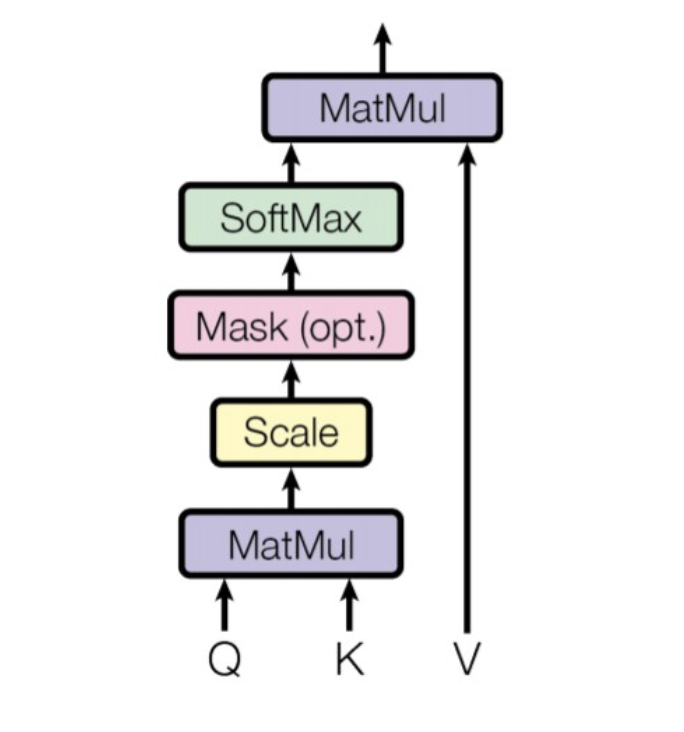

In [ ]:
class FSAttention(nn.Module):
    """Factorized Self-Attention"""

    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity() ## Input 그대로를 출력

    def forward(self, x):
        # x = [batch*n_t, n_h*n_w, dim]
        b, n, _, h = *x.shape, self.heads
        # b = batch*n_t
        # n = n_h*n_w
        # h=heads

        qkv = self.to_qkv(x)
        qkv = qkv.chunk(3, dim=-1)
        # self.to_qkv(x) = [batch*n_t, n_h*n_w, inner_dim*3]
        # qkv = [3, batch*n_t, n_h*n_w, inner_dim]

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # q, k, v = [batch*n_t, n_h*n_w, (heads * dim_head)] -> [batch*n_t, heads, n_h*n_w, dim_head]

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        # q*k = [batch*n_t, heads, query_dim, dim_head] * [batch*n_t, heads, key_dim, dim_head] 
        #    -> [batch*n_t, heads, query_dim, key_dim]

        attn = self.attend(dots)
        # attn = [batch*n_t, heads, query_dim, key_dim]

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        # attn*v = [batch*n_t, heads, query_dim, key_dim] * [batch*n_t, heads, value_dim, dim_head]
        #       -> [batch*n_t, heads, query_dim, dim_head]

        out = rearrange(out, 'b h n d -> b n (h d)')
        # out = [batch*n_t, n_h*n_w, heads*dim_head]

        # out = Dropout(Linear(out))
        # out = [batch*n_t, n_h*n_w, dim]
        return self.to_out(out)

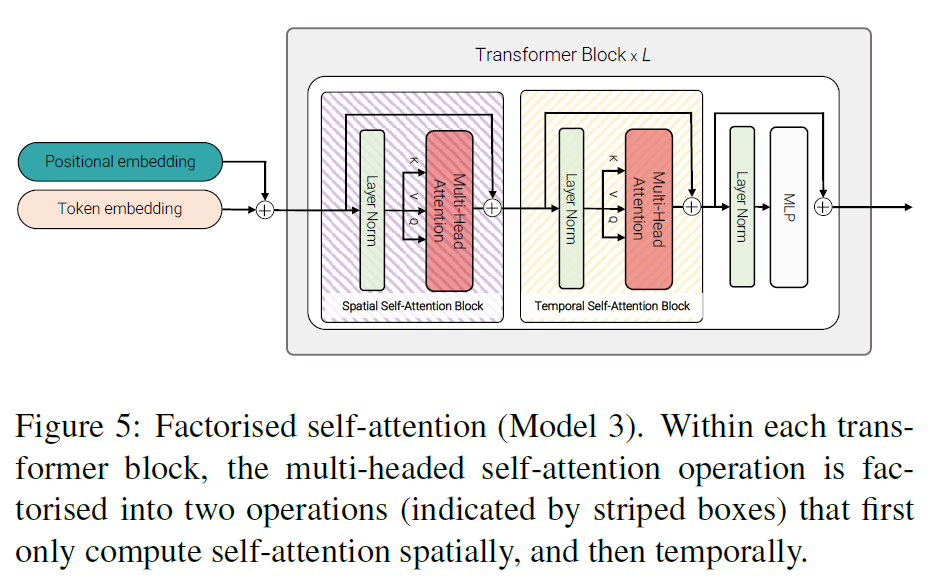
<br>1) spatial self-attention: z from R^1×nt·nh·nw·d to R^nt×nh·nw·d
<br>2) temporal self-attention: zt to R^nh ·nw ×nt ·d

In [ ]:
class FSATransformerEncoder(nn.Module):
    """Factorized Self-Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(nn.ModuleList(
                [PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
                 ]))
            # PreNorm = LayerNorm > (FSAttention/FeedForward)
            # FeedForward = Linear(dim>hidden_dim) > GELU > Dropout > Linear(hidden_dim, dim) > Dropout

    def forward(self, x):
        # x = [batch, n_t, n_h*n_w, dim]
        b = x.shape[0]
        # b = batch

        x = torch.flatten(x, start_dim=0, end_dim=1)
        # extract spatial tokens from x
        # x = [batch*n_t, n_h*n_w, dim]

        for sp_attn, temp_attn, ff in self.layers:
            # Y_s = MSA(LA(Z_l))+Z_l -> Spatial Attention

            sp_attn_x = sp_attn(x) + x
            ## sp_attn_x = [batch*n_t, n_h*n_w, dim]

            # Reshape tensors for temporal attention

            sp_attn_x = sp_attn_x.chunk(b, dim=0)
            ## sp_attn_x = [batch, n_t, n_h*n_w, dim]

            sp_attn_x = [temp[None] for temp in sp_attn_x] # tuple to list
            sp_attn_x = torch.cat(sp_attn_x, dim=0).transpose(1, 2)
            ## torch.cat(sp_attn_x, dim=0) list to torch
            ## sp_attn_x = [batch, n_h*n_w, n_t, dim]

            sp_attn_x = torch.flatten(sp_attn_x, start_dim=0, end_dim=1)
            ## sp_attn_x = [batch*n_h*n_w, n_t, dim]
            ## temporal attention 입력값 > time에 대해서

            # Y_t = MSA(LA(Y_s))+Y_s -> Temporal Attention

            temp_attn_x = temp_attn(sp_attn_x) + sp_attn_x
            ## temp_attn_x = [batch*n_h*n_w, n_t, dim]

            # Z_l+1 = MLP(LA(Y_t))+Y_t -> MLP

            x = ff(temp_attn_x) + temp_attn_x
            ## x = [batch*n_h*n_w, n_t, dim]

            # Again reshape tensor for spatial attention

            x = x.chunk(b, dim=0)
            ## x = [batch, n_h*n_w, n_t, dim]

            x = [temp[None] for temp in x] # tuple to list
            x = torch.cat(x, dim=0).transpose(1, 2)
            ## x = [batch, n_t, n_h*n_w, dim]

            x = torch.flatten(x, start_dim=0, end_dim=1)
            ## x = [batch*n_t, n_h*n_w, dim]
            # 다음 layer spatial transformer 입력을 위해
        
        ## x = [batch*n_t, n_h*n_w, dim]
        
        x = x.chunk(b, dim=0)
        # x = [batch, n_t, n_h*n_w, dim]

        x = [temp[None] for temp in x] # tuple to list
        x = torch.cat(x, dim=0) # list to torch
        x = torch.flatten(x, start_dim=1, end_dim=2)
        # x = [batch, n_t*n_h*n_w, dim]
        return x

### ViViT model (model 3, 4)

initialise the positional embeddings by repeating them temporally from
- R^nw·nh×d to R^nt ·nh ·nw ×d 

all tokens with the same spatial index have the same embedding which is then fine-tuned.

출처: https://github.com/drv-agwl/ViViT-pytorch

In [ ]:
class ViViTBackbone(nn.Module):
    """ Model-3 backbone of ViViT """

    def __init__(self, t, h, w, patch_t, patch_h, patch_w, num_classes, dim, depth, heads, mlp_dim, dim_head=3,
                 channels=3, mode='tubelet', device='cuda', emb_dropout=0., dropout=0., model=3):
        super().__init__()

        assert t % patch_t == 0 and h % patch_h == 0 and w % patch_w == 0, "Video dimensions should be divisible by " \
                                                                           "tubelet size "

        self.T = t
        self.H = h
        self.W = w
        self.channels = channels
        self.t = patch_t
        self.h = patch_h
        self.w = patch_w
        self.mode = mode
        self.device = device

        self.nt = self.T // self.t
        self.nh = self.H // self.h
        self.nw = self.W // self.w

        tubelet_dim = self.t * self.h * self.w * channels ## patch time * patch height * patch width * channels

        self.to_tubelet_embedding = nn.Sequential(
            Rearrange('b c (n_t pt) (n_h ph) (n_w pw) -> b n_t (n_h n_w) (pt ph pw c)', pt=self.t, ph=self.h, pw=self.w),
            nn.Linear(tubelet_dim, dim)
        )

        # repeat same spatial position encoding temporally
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, self.nh * self.nw, dim)).repeat(1, self.nt, 1, 1)

        self.dropout = nn.Dropout(emb_dropout)

        if model == 3:
            self.transformer = FSATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)
        elif model == 4:
            assert heads % 2 == 0, "Number of heads should be even"
            self.transformer = FDATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        """ x: (batch, Channels, Time, Height, Width) """

        tokens = self.to_tubelet_embedding(x)
        # rearrange
        #   [batch, Channels, Time, Height, Width] > [batch, n_t(Time//batch_time), n_h*n_w, pt*ph*pw*Channels]
        # Linear
        #   [batch, n_t(Time//batch_time), n_h*n_w, pt*ph*pw*Channels] > [batch, n_t(Time//batch_time), n_h*n_w, dim=input_value]
        # tokens = [batch, n_t, n_t*n_w, dim]

        tokens += self.pos_embedding
        # self.pos_embedding = [1, n_t, n_h*n_w, dim]
        ##  random [1, 1, n_h*n_w, dim] * n_t
        ##  -> 위치에 따라 다른 position embedding (spatial token)
        # tokens = [batch, n_t, n_h*n_w, dim]
        ##  batch마다 positional embedding이 더해짐

        '''
        1. model == 3
          self.transformer = FSATransformerEncoder(dim, depth, heads, dim_head, mlp_dim, self.nt, self.nh, self.nw, dropout)
          self.transformer(tokens) > [batch, n_t*n_h*n_w, dim]
        2. model == 4
          self.transformer = FDATransformerEncoder(dim, depth, heads, dim_head, mlp_dim, self.nt, self.nh, self.nw, dropout)
          self.transformer(tokens) > [batch, n_t*n_h*n_w, dim]
        
        x = x.mean(dim=1) > n_t*n_h*n_w의 값에 대해서 평균
          > x = [batch, dim]
        x = self.to_latent(x) > deepcopy로 생각
        self.mlp_head = LayerNorm > Linear(dim > num_classes)

        out = [batch, num_classes]
        '''
        tokens = self.dropout(tokens)
        x = self.transformer(tokens)
        x = x.mean(dim=1)
        x = self.to_latent(x)
        return self.mlp_head(x)

### Factorised Encoder (Model 2)

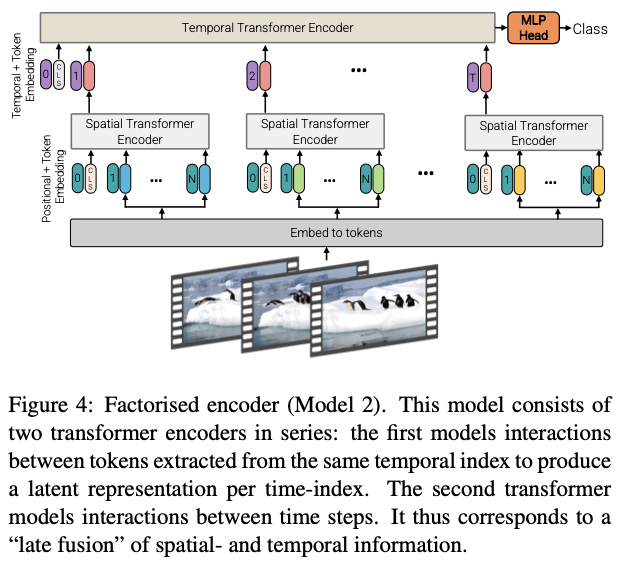

출처: https://github.com/rishikksh20/ViViT-pytorch

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # x = [batch*time, n_h*n_w+1, dim]
        b, n, _, h = *x.shape, self.heads
        # b = batch*time
        # n = n_h*n_w+1
        # h = heads

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        # qkv = [3, batch*time, n_h*n_w+1, innder_dim]

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        # q, k, v = [batch*time, n_h*n_w+1, innder_dim] > [batch*time, heads, n_h*n_w+1, dim_head]

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        ## q*k = [batch*time, heads, query_dim, dim_head] * [batch*time, heads, key_dim, dim_head] 
        ##    -> [batch*time, heads, n_h*n_w+1, key_dim]

        attn = dots.softmax(dim=-1) # Softmax(q*k)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        ## attn*v = [batch*time, heads, query_dim, key_dim] * [batch*time, heads, value_dim, dim_head] 
        ##       -> [batch*time, heads, n_h*n_w+1, dim_head]
        ##       -> [batch*time, n_h*n_w+1, inner_dim]
        
        out =  self.to_out(out)
        ## out = Dropout(Linear(out))
        # out = [batch*n_t, n_h*n_w, inner_dim] > [batch*n_t, n_h*n_w, dim]
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
            # FeedForward = Linear(dim>hidden_dim) > GELU > Dropout > Linear(hidden_dim, dim) > Dropout

    def forward(self, x):
        # x = [batch*time, n_h*n_w+1, dim]
        ## LayerNorm(FeedForward(Attention(x)) for layer_len)
        for attn, ff in self.layers:
            x = attn(x) + x # Attention
            # x = [batch*n_t, n_h*n_w, dim]

            x = ff(x) + x # FeedForward
            # x = [batch*n_t, n_h*n_w, dim]
        return self.norm(x) # LayerNorm

In [ ]:
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # x = [batch, time, channels, height, width]
        # Uniform frame sampling

        x = self.to_patch_embedding(x)
        # rearrange
        #   [batch, time, channels, height, width] > [batch, time, n_h*n_w, p1*p2*channels]
        # Linear
        #   [batch, time, n_h*n_w, p1*p2*channels] > [batch, time, n_h*n_w, dim=input_value]
        
        # x = [batch, time, n_h*n_w, dim]

        b, t, n, _ = x.shape
        # b = batch
        # t = time
        # n = n_h*n_w

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b=b, t=t)
        # self.space_token = [1, 1, dim]
        # cls_space_tokens = [batch, time, 1, dim]
        #   > p1*p2*channels에 따라 다른 값
        #   > 그 외는 반복

        x = torch.cat((cls_space_tokens, x), dim=2)
        # x = [batch, time, n_h*n_w+1, dim]

        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)
        # self.pos_embedding = [1, time, n_h*n_w + 1, dim]
        # x = [batch, time, n_h*n_w+1, dim]
        # batch마다 같은 embedding 값이 더해짐

        x = rearrange(x, 'b t n d -> (b t) n d')
        # x = [batch*time, n_h*n_w+1, dim]

        x = self.space_transformer(x)
        # x = [batch*time, n_h*n_w+1, dim]

        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)
        # x = [batch, time, dim]

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        # self.temporal_token = [1, 1, dim]
        # cls_temporal_tokens = [batch, 1, dim]
        #   > time에 따라 다른 값

        x = torch.cat((cls_temporal_tokens, x), dim=1)
        # x = [batch, time+1, dim]

        x = self.temporal_transformer(x)
        # x = [batch, time+1, dim]
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        '''
        1. pool == 'mean'
          > time+1 에 따라서 mean
          x = [time+1, dim]
        
        2. pool != 'mean'
          > batch에 따라서 mean
          x = [batch, dim]
        '''

        # Linear(LayerNorm(x))
        # out = [batch, dim] > [batch, num_classes]
        return self.mlp_head(x)
    

### model example

model - 2

In [ ]:
# batch x time x channels x height x width
x = torch.ones([3, 16, 3, 224, 224])

vivit2 = ViViT(
          image_size=224, 
          patch_size=16, 
          num_classes=10, 
          num_frames=16
        ).to(device)
# parameters = filter(lambda p: p.requires_grad, model.parameters())
# parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
# print('Trainable Parameters: %.3fM' % parameters)

out2 = vivit2(x)
print("Shape of out :", out2.shape)

Shape of out : torch.Size([3, 10])


model - 3

In [ ]:
# batch x channels x time x height x width
x = torch.rand(4, 3, 32, 64, 64).to(device)

vivit3 = ViViTBackbone(
            t=32, 
            h=64, 
            w=64, 
            patch_t=8, 
            patch_h=4, 
            patch_w=4, 
            num_classes=10, 
            dim=512, 
            depth=6, 
            heads=10, 
            mlp_dim=8, 
            model=3
          ).to(device)
out3 = vivit3(x)
out3.shape
print("Shape of out :", out3.shape)

Shape of out : torch.Size([4, 10])


model - 4

In [ ]:
vivit4 = ViViTBackbone(
            t=32, 
            h=64, 
            w=64, 
            patch_t=8, 
            patch_h=4, 
            patch_w=4, 
            num_classes=10, 
            dim=512, 
            depth=6, 
            heads=10, 
            mlp_dim=8, 
            model=4
          ).to(device)
out4 = vivit4(x)
out4.shape
print("Shape of out :", out4.shape)

Shape of out : torch.Size([4, 10])
